In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import matplotlib.colors as colors
import os
from mycolorpy import colorlist as mcp

data_dir = os.getenv("DATADIR")
plt.style.use(data_dir+'bl.mplstyle')
matplotlib.rcParams['lines.markersize'] = 3.

# Add Extinction
def add_extinction(row, Av,extinction_coeff):
    dered_row =  row[mag_cols].copy()
    for mag in mag_cols:
        dered_row[mag] = row[mag] + (extinction_coeff[mag] * Av )
    return dered_row

# Remove Extinction
def correct_extinction(row, Av, extinction_coeff):
    dered_row  = row.copy()
    for mag in row.keys():
        dered_row[mag] = row[mag] - (extinction_coeff[mag] * Av )
    return dered_row

# Convert from absolute to apparent magnitude
def Absolute_to_Apparent(AbsoluteMag,distance):
    return AbsoluteMag + 5 * (np.log10(distance/10))

# Custom colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# Constants
mag_cols = ['UVW2', 'UVM2', 'UVW1', 'U', 'B', 'V', 'I']
eff_wav = [1928,2246,2600,3639.3,4350.6,5369.6,7609.2] 
extinction_coeffs = {}
extinction_coeffs['LMC'] = {
    'UVW2' : 2.644541680555541,
    'UVM2' : 2.7233599880955124,
    'UVW1' : 2.3536449902431045,
    'U'  : 1.5634790597438197,
    'B'  : 1.3170082045312625,
    'V'  : 1.0333402844940784,
    'I'  : 0.7366865234305091,
}
extinction_coeffs['SMC'] = {
		'UVW2' : 3.522767303652845,
		'UVM2' : 3.062652780996107,
		'UVW1' : 2.7436011426496876,
		'U'  : 1.746851127566682,
		'B'  : 1.4073996800012445,
		'V'  : 1.0353852912271932,
		'I'  : 0.5911705440475679,
	}
lmc_model = pd.read_csv(data_dir+'1_Models/StrippedStars/stripped_stars_Z0.006_ABmag.txt',comment='#',delimiter='\t')
lmc_model.columns = list(lmc_model.keys().str.strip(' '))

smc_model = pd.read_csv(data_dir+'1_Models/StrippedStars/stripped_stars_Z0.002_ABmag.txt',comment='#',delimiter='\t')
smc_model.columns = list(smc_model.keys().str.strip(' '))


stripped_star_mass = 2.2
synth_sed_lmc = lmc_model.loc[np.argmin(np.abs(lmc_model.Mstrip-stripped_star_mass)) ,lmc_model.keys()[2:]].copy()
synth_sed_smc = smc_model.loc[np.argmin(np.abs(smc_model.Mstrip-stripped_star_mass)) ,smc_model.keys()[2:]].copy()
synth_mass = {'LMC':lmc_model.loc[np.argmin(np.abs(lmc_model.Mstrip-stripped_star_mass)) ,'Mstrip'], 'SMC':smc_model.loc[np.argmin(np.abs(smc_model.Mstrip-stripped_star_mass)) ,'Mstrip']}
print('LMC stripped star mass: ',lmc_model.loc[np.argmin(np.abs(lmc_model.Mstrip-stripped_star_mass)) ,'Mstrip'])
print('SMC stripped star mass: ',smc_model.loc[np.argmin(np.abs(smc_model.Mstrip-stripped_star_mass)) ,'Mstrip'])
synth_sed = {'LMC':synth_sed_lmc, 'SMC':synth_sed_smc}

Avs = {'LMC':0.38, 'SMC':0.22}
models = {'LMC':lmc_model, 'SMC':smc_model}
distances = {'LMC':50e3, 'SMC':60.6e3}

# Get our candidates 
sums = pd.read_csv(data_dir+'0_SUMS_Catalogs/CandidateCatalog/3_stripped_star_candidates.csv')

lmc_sums = sums[sums.ra > 30]
smc_sums = sums[sums.ra < 30]

viridis_cmap = truncate_colormap(plt.get_cmap('viridis'), 0.2, 0.8,n=8)
plasma_cmap = truncate_colormap(plt.get_cmap('plasma'), 0.2, 0.8,n=8)


LMC stripped star mass:  2.33526275
SMC stripped star mass:  2.20677079


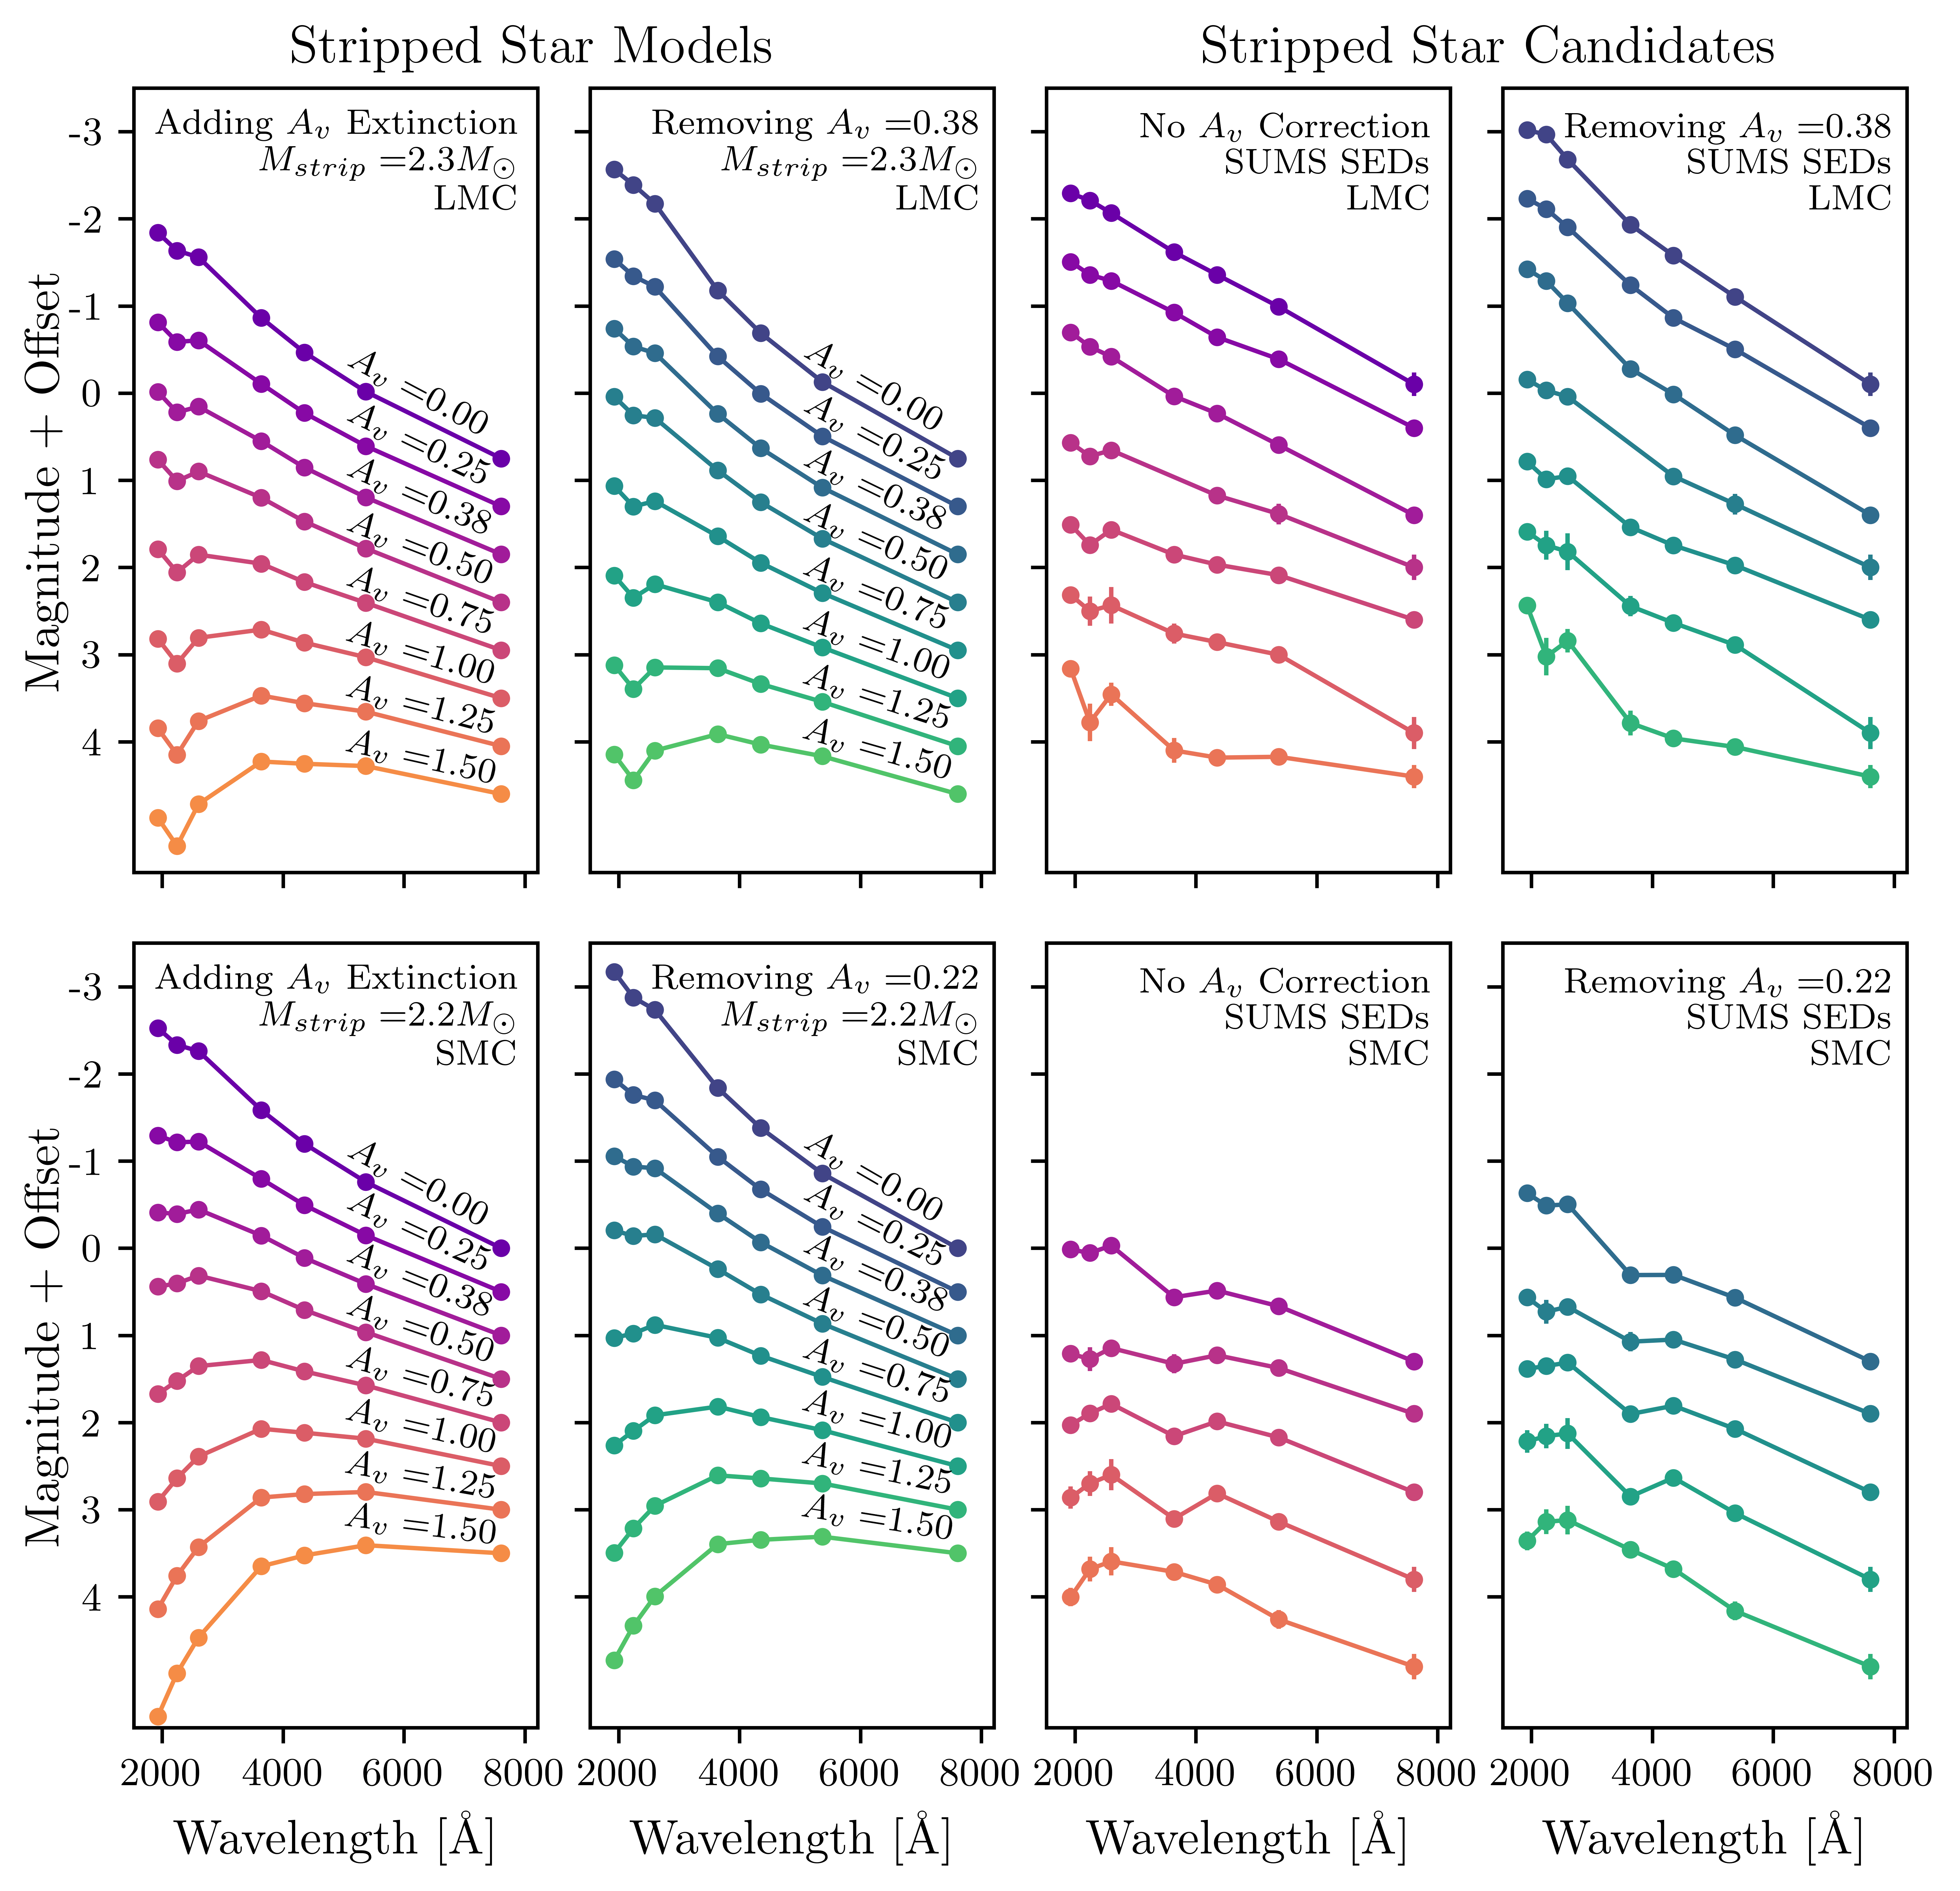

In [51]:
# Plot 
avs = [0.0, 0.25, 0.38, 0.5,0.75,1.0,1.25,1.5]
avs_labels = ['0.00', '0.25', '0.38', '0.50','0.75','1.00','1.25','1.50','1.75','2.00']
sed_cols = ['uvw2','uvm2','uvw1','U','B','V','I'] # no extinction
err_cols = ['uvw2_err','uvm2_err','uvw1_err','e_U','e_B','e_V','e_I']
cap_cols = ['UVW2', 'UVM2', 'UVW1', 'U', 'B', 'V', 'I']

textpad_y = -0.1
textpad_x = -2500
fig_w = 3.35 * 2 + 0.5
fig_h = 3.35 * 2 #- 1.
cmap = plt.get_cmap('cividis')
new_cmap = truncate_colormap(cmap, 0.2, 0.8,n=len(avs))
f, axes = plt.subplots(2,4, figsize=(fig_w,fig_h),dpi=1000)


lmc_ids = [f'SUMS_{id}' for id in ['893ce','1e0cd','24c3e','2107d','19f7f','73676','77d2b']]
smc_ids = [f'SUMS_{id}' for id in ['c4848','b168b','c0248','8e095','c285c','c4e6c','c3e56']]


y_adjust = 0

[ax.set_ylim(5.5, -3.5) for ax in axes.flatten()]

[ax.set_xlim(np.min(eff_wav)-400,np.max(eff_wav)+600) for ax in axes.flatten()]
xticks = np.arange(2000,10000,2000)
[ax.set_xticks(xticks) for ax in axes.flatten()]
[ax.set_xticklabels([]) for ax in axes.flatten()]
[ax.set_xticklabels([str(int(x)) for x in xticks]) for ax in axes[1,:]]
[ax.set_xlabel(r'Wavelength [$\mathrm{\AA}$]') for ax in axes[1,:]]

yrange = np.arange(-3., 5., 1)
ystring = [str(int(i)) for i in yrange]
[ax.set_yticks(yrange) for ax in axes.flatten()]
[ax.set_yticklabels([]) for ax in axes.flatten()]
[ax.set_yticklabels(ystring) for ax in axes[:,0]]

# Add title text at top of figure between subplots 
axes[0,0].text(0.99, 1.05, 'Stripped Star Models', ha='center', va='center', transform=axes[0,0].transAxes, fontsize=12)
axes[0,2].text(2.23, 1.05, 'Stripped Star Candidates', ha='center', va='center', transform=axes[0,1].transAxes, fontsize=12)

for  axs, gal,selected_ids in zip([axes[0,:], axes[1,:]], ['LMC','SMC'], [lmc_ids, smc_ids]):    

    sed = synth_sed[gal]
    Av = Avs[gal]
    mass = synth_mass[gal]
    extinction_coeff = extinction_coeffs[gal]
    distance = distances[gal]
    
    if gal == 'LMC':
        adj = 0.5
        c = 0.55
        sep = [-1, -0.5, 0.5,   1.1,   1.7,    3.,    3.5]
        sep = np.array(sep) + 0.9
        model_adj = 0.75
        cand_adj = 0
        av_text_adjust = -0.25
        rot1_c = 2.2
        rot2_c = 2
    else:
        c = 0.5
        sep = [-1.5, -0.5, 0.5,   1.1,   2,    3,    4]
        sep = np.array(sep) + 0.8
        model_adj = 0.
        cand_adj = 0
        av_text_adjust = -0.4
        rot1_c = 3
        rot2_c = 3

    for key in mag_cols:
        sed[key] = Absolute_to_Apparent(sed[key],distance)


    axs[0].annotate(r'Adding $A_{v}$ Extinction''\n'r'$M_{strip}=$'+f'{mass:.1f}'+r'$M_\odot$''\n'+gal, (7900,-2.1),ha='right',fontsize=8)
    axs[1].annotate(r'Removing $A_{v}=$'+f'{Av}'+'\n'r'$M_{strip}=$'+f'{mass:.1f}'+r'$M_\odot$''\n'+gal, (7990,-2.1),ha='right',fontsize=8)
    axs[2].annotate(r'No $A_{v}$ Correction''\nSUMS SEDs''\n'+gal, (7900,-2.1),fontsize=8,ha='right')
    axs[3].annotate(r'Removing $A_{v}=$'+f'{Av}'+'\nSUMS SEDs''\n'+gal, (7990,-2.1),fontsize=8,ha='right')

    
    counter = 0
    models = []
    norm_models = []
    rot1 = -28
    rot2 = -30

    # Stripped Star Models
    for i,av in enumerate(avs):

        # First Column - Add extinction 
        model = add_extinction(sed,av,extinction_coeff) 
        normalization = model[mag_cols[-1]]
        norm_model = model - normalization + counter  + model_adj
        axs[0].plot(eff_wav, norm_model.values, label=r'$A_{v}$='+str(av), marker='o',color=plasma_cmap(i/len(avs)))
        text_x = 5000
        text_y = norm_model[mag_cols[-1]] + av_text_adjust + y_adjust
        axs[0].annotate(r'$A_{v} = $'+avs_labels[i], (text_x,text_y),rotation=rot1,fontsize=8)
         
        # Second Column - Remove extinction
        dered_model = correct_extinction(model,Av,extinction_coeff)
        normalization = dered_model[mag_cols[-1]]
        norm_dered_model = dered_model - normalization + counter  + model_adj
        text_y = norm_dered_model[mag_cols[-1]] + av_text_adjust + y_adjust - 0.05
        axs[1].plot(eff_wav, norm_dered_model.values, label=r'$A_{v}$='+str(av), marker='o',color=viridis_cmap(i/len(avs)))
        axs[1].annotate(r'$A_{v} = $'+avs_labels[i], (text_x , text_y),rotation=rot2,fontsize=8)
        
        counter += c

        rot1 += rot1_c
        rot2 += rot2_c
        y_adjust += 0.02


    # Stripped Star Candidates
    for ind, sum_id in enumerate(selected_ids):
        # Third column - Candidates without extinction correction
        row = sums[sums.SUMS_ID == sum_id]
        if len(row) == 0:
            continue
        selected_sed = row[sed_cols].values.astype(float)[0]
        selected_normal = selected_sed[-1]
        selected_err = row[err_cols].values.astype(float)[0]

        # Ignore NaN values
        wv = np.array(eff_wav)[np.isfinite(selected_sed)]
        selected_err = selected_err[np.isfinite(selected_sed)]
        col = np.array(cap_cols)[np.isfinite(selected_sed)]
        selected_sed = selected_sed[np.isfinite(selected_sed)]

        # Normalize and adjust the offset
        y = selected_sed - selected_normal + sep[ind] + cand_adj
        
        # Save
        selected_sed = pd.DataFrame(columns=col)
        selected_sed.loc[0] = y
        
        axs[2].errorbar(wv, y, yerr=selected_err,color=plasma_cmap(ind/len(avs)),marker='o')

        # Fourth column - Candidates with extinction correction
        dered_selected_sed = correct_extinction(selected_sed,Av,extinction_coeff).values[0]
        dered_selected_normal = dered_selected_sed[-1]
        y = dered_selected_sed - dered_selected_normal + sep[ind] +cand_adj
        axs[3].errorbar(wv, y, yerr=selected_err,color=viridis_cmap(ind/len(avs)),label='Observed',marker='o')
       

    # Formatting
    axs[0].set_ylabel('Magnitude + Offset',labelpad=0.1)
    
plt.subplots_adjust(wspace=0.13, hspace=0.09)
# Save 
plt.savefig('SED_Extinction.pdf',bbox_inches='tight')

